In [1]:
import warnings
warnings.filterwarnings("ignore")

import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rc('pdf', fonttype=42) # Avoid type 3 fonts

sns.set_theme(style="white")
sns.set_palette(sns.color_palette("tab10"))
plt.rcParams.update({"xtick.bottom" : True, "ytick.left" : True}) # enables minor ticks

In [2]:
BASE_DIR = '../android/'
RESULTS_DIR = os.path.join(BASE_DIR, '../results/small-hw-support-2024-05-25-125045/')

TESTS = {
    "decrypt": "testHiddenSloth_withSmall_withOpDecrypt",
    "decryptCached": "testHiddenSloth_withSmall_withOpDecryptWithCachedKey",
    "ratchet": "testHiddenSloth_withSmall_withOpRatchet",
}


def read_device_info(path):
    with open(path) as f:
        x = json.load(f)
        
    name = x['name'].replace('"', '')
    name = name.replace(' 5G', '')
        
    os = x['os']
    if '.' in os:
        os = os[:os.find('.')]
    
    return {
        'name': name,
        'os': int(os),
    }


def read_sloth_bench_results(dir_path, test_name):
    allS, allDurations = [], []
    
    with open(os.path.join(dir_path, f'{test_name}.json')) as f:
        x = json.load(f)
        
        for m in x:
            d = m['data']
            if m['tag'] != 'LogTracer' or test_name not in d:
                continue

            _, _, _, s, startNs, finishNs = d.split(' ')
            allS.append(int(s.split('=')[1]))
        
            startNs = int(startNs.split('=')[1])
            finishNs = int(finishNs.split('=')[1])
            allDurations.append((finishNs - startNs) / 1_000_000) # NS to MS
    
    return {
        's': allS,
        'duration': allDurations, 
    }


def read_job_result(job_path, test_id, test_name):
    device_info = read_device_info(os.path.join(job_path, "device.json"))
    bench_results = read_sloth_bench_results(job_path, test_name)
    
    return {**device_info, **{'test': test_id}, **bench_results}

                  
def read_all_jobs():
    all_data = []
    for job_name in sorted(os.listdir(RESULTS_DIR)):
        job_path = os.path.join(RESULTS_DIR, job_name)
        
        if not os.path.isdir(job_path):
            continue
            
        for test_id, test_name in TESTS.items():
            x = read_job_result(job_path, test_id, test_name)
            if len(x['s']) < 10: continue
            all_data.append(x)
    return pd.json_normalize(all_data)
        
df = read_all_jobs()
df = df.explode(['s', 'duration'], ignore_index=True)
df = df.astype({'duration': 'float64'})

df.sample(10)

,name,os,test,s,duration
309,Samsung Galaxy S21,12,decrypt,1048576,428.185729
179,Google Pixel 7,13,decrypt,10485760,480.165242
56,Google Pixel 3,10,decryptCached,1048576,5.689324
287,Google Pixel 7,13,ratchet,33158896,673.703410
151,Google Pixel 7,13,decrypt,1048576,486.930217
182,Google Pixel 7,13,decrypt,33158896,505.031128
423,Samsung Galaxy S21,12,ratchet,10485760,588.057448
94,Google Pixel 3,10,decryptCached,104857600,240.317888
216,Google Pixel 7,13,decryptCached,3315888,44.244832
199,Google Pixel 7,13,decrypt,104857600,760.154704


Operation: ratchet


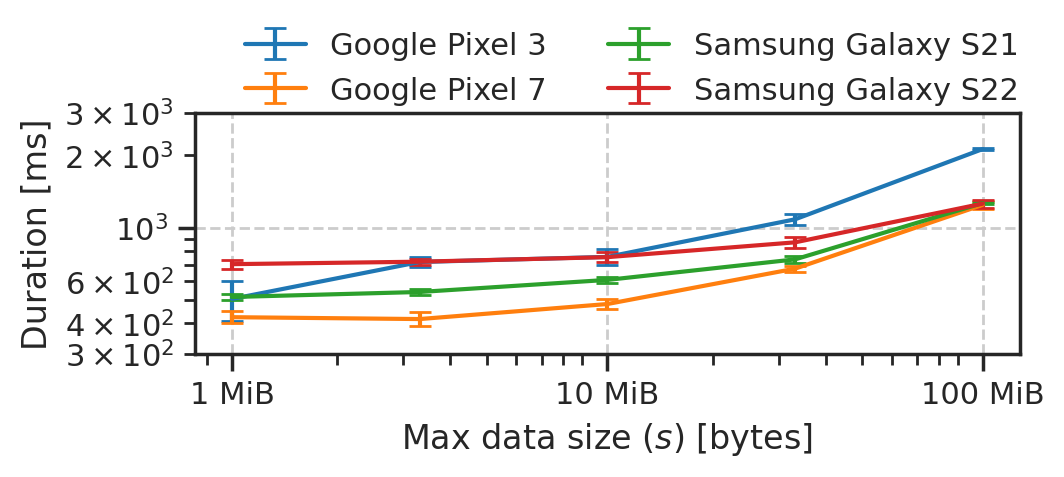

In [3]:
#
# Line plot with error bars for ratchet operation given payload size
#

MIB = 1024 * 1024

def draw_plot_for_test(df, test_id):
    fig, ax = plt.subplots()
    fig.set_size_inches((5.5, 2.2))
    
    df = df[df.test == test_id]

    def draw_plot_for_name(data, ax, name):
        grouped = data[data.name==name][["s", "duration"]].groupby("s", as_index=False)

        means = grouped.mean()
        errors = grouped.std()

        handle = ax.errorbar(
            x=means["s"], y=means["duration"], yerr=errors["duration"],
            fmt='', ls='-',
            ms=5, capsize=4)
        handle.set_label(name)

    for name in sorted(list(set(df['name']))):
        draw_plot_for_name(df, ax, name)

    print(f"Operation: {test_id}")

    ax.set_xlabel("Max data size ($s$) [bytes]")
    ax.set_xscale("log")
    ax.set_xticks([1*MIB, 10*MIB, 100*MIB])
    ax.set_xticklabels(["1 MiB", "10 MiB", "100 MiB"])


    ax.set_ylabel("Duration [ms]")
    ax.set_yscale("log")
    ax.set_ylim((300, 3*1_000))

    ax.grid(ls='--')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(0.97, 1.13), frameon=False)

    fig.tight_layout()
    fig.savefig("output/android-hidden-sloth-bench.pdf", bbox_inches='tight')

    
for test_id in ("ratchet",):
    draw_plot_for_test(df, test_id)

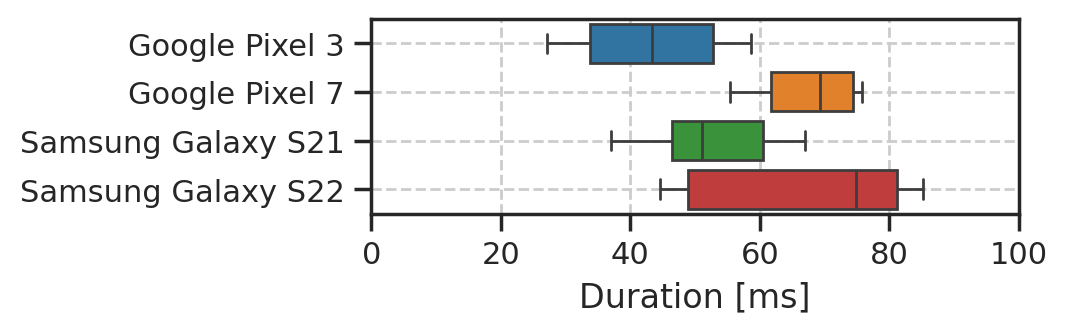

In [4]:
#
# Box plot for decrypt operation under two payload sizes
#

PAYLOAD_SIZES = (10 * MIB,)

fig, axs = plt.subplots(len(PAYLOAD_SIZES), 1, sharex=True)
axs = [axs]
fig.set_size_inches((5.5, len(PAYLOAD_SIZES) * 1.85))

for ax, payload_size in zip(axs, PAYLOAD_SIZES):
    d = df[(df.test=='decryptCached') & (df.s==payload_size)]
    sns.boxplot(
        data=d,
        y='name',
        x='duration',
        hue='name',
        ax=ax,
        showfliers = False,
        dodge=False,
    )

    ax.set_ylabel(None)

    ax.set_xlabel("Duration [ms]")
    # ax.set_xscale("log")
    ax.set_xlim((0, 100))

    ax.grid(ls='--')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend().remove()

fig.tight_layout()
fig.savefig("output/android-hidden-sloth-decrypt-box.pdf", bbox_inches='tight')